# Perform statistical test in each repo between -1 and +1 month from HN submission

Setup. The metrics csv is assumed to have been filtered only for repositories that contains metrics at least 6 months before and after Hackernews submission date.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
from datetime import datetime

# Load the data
df = pd.read_csv('../dataset/metrics-hn-gh-ai-[6months-before-after-hn].csv')

# Convert date columns to datetime
df['hn_submission_date'] = pd.to_datetime(df['hn_submission_date'])
df['month'] = pd.to_datetime(df['month'])


Format dataframe for statistical analysis. The Historical GH metrics dataset is initially on a month-by-month format. Here we identify HN submission date in each repository, and reference the month before and after the submission month.

In [3]:
# Create a relative month column (months from HN submission)
def calculate_months_from_submission(row):
    submission_month = pd.to_datetime(row['hn_submission_date']).replace(day=1)
    current_month = row['month']
    return ((current_month.year - submission_month.year) * 12 +
            current_month.month - submission_month.month)

df['months_from_submission'] = df.apply(calculate_months_from_submission, axis=1)

# Filter for just the month before (-1) and month after (1) HN submission
before_after_df = df[df['months_from_submission'].isin([-1, 1])]

# Create a comparison dataframe
repos = before_after_df['repo_full_name'].unique()
metrics = ['new_stars', 'new_forks', 'new_commits', 'new_prs', 'active_contributors']

comparison_data = []
for repo in repos:
    repo_data = before_after_df[before_after_df['repo_full_name'] == repo]

    before = repo_data[repo_data['months_from_submission'] == -1]
    after = repo_data[repo_data['months_from_submission'] == 1]

    # Skip if we don't have both before and after data
    if before.empty or after.empty:
        continue

    for metric in metrics:
        before_val = before[metric].values[0]
        after_val = after[metric].values[0]

        comparison_data.append({
            'repo_full_name': repo,
            'metric': metric,
            'before': before_val,
            'after': after_val,
            'difference': after_val - before_val,
            'fold_change': after_val / before_val if before_val != 0 else np.nan
        })

comparison_df = pd.DataFrame(comparison_data)


Perform statistical test

In [4]:
# Statistical analysis
results = {}
for metric in metrics:
    metric_data = comparison_df[comparison_df['metric'] == metric]

    # Check normality with Shapiro-Wilk test
    if len(metric_data) >= 3:  # Shapiro needs at least 3 samples
        _, p_norm_before = stats.shapiro(metric_data['before'])
        _, p_norm_after = stats.shapiro(metric_data['after'])
        is_normal = (p_norm_before > 0.05) and (p_norm_after > 0.05)
    else:
        is_normal = False  # Default to non-parametric with small sample size

    # Perform appropriate test
    if is_normal:
        _, p_value = stats.ttest_rel(metric_data['before'], metric_data['after'])
        test_name = "Paired t-test"
    else:
        _, p_value = stats.wilcoxon(metric_data['before'], metric_data['after'])
        test_name = "Wilcoxon signed-rank test"

    # Calculate basic statistics
    mean_before = metric_data['before'].mean()
    mean_after = metric_data['after'].mean()
    median_before = metric_data['before'].median()
    median_after = metric_data['after'].median()
    mean_diff = metric_data['difference'].mean()
    median_diff = metric_data['difference'].median()

    results[metric] = {
        'test': test_name,
        'p_value': p_value,
        'mean_before': mean_before,
        'mean_after': mean_after,
        'median_before': median_before,
        'median_after': median_after,
        'mean_diff': mean_diff,
        'median_diff': median_diff,
        'significant': p_value < 0.05
    }

In [5]:
# Print results
print("Statistical Test Results:")
for metric, res in results.items():
    print(f"\n{metric}:")
    print(f"  Test: {res['test']}")
    print(f"  p-value: {res['p_value']:.6f}")
    print(f"  Mean Before: {res['mean_before']:.2f}, Mean After: {res['mean_after']:.2f}")
    print(f"  Median Before: {res['median_before']:.2f}, Median After: {res['median_after']:.2f}")
    print(f"  Mean Difference: {res['mean_diff']:.2f}")
    print(f"  Significant: {'Yes' if res['significant'] else 'No'}")

Statistical Test Results:

new_stars:
  Test: Wilcoxon signed-rank test
  p-value: 0.000485
  Mean Before: 246.37, Mean After: 338.84
  Median Before: 28.00, Median After: 56.00
  Mean Difference: 92.47
  Significant: Yes

new_forks:
  Test: Wilcoxon signed-rank test
  p-value: 0.003692
  Mean Before: 32.53, Mean After: 44.09
  Median Before: 3.00, Median After: 5.00
  Mean Difference: 11.56
  Significant: Yes

new_commits:
  Test: Wilcoxon signed-rank test
  p-value: 0.312277
  Mean Before: 82.43, Mean After: 89.86
  Median Before: 11.00, Median After: 10.00
  Mean Difference: 7.42
  Significant: No

new_prs:
  Test: Wilcoxon signed-rank test
  p-value: 0.105604
  Mean Before: 45.94, Mean After: 53.66
  Median Before: 3.00, Median After: 3.00
  Mean Difference: 7.72
  Significant: No

active_contributors:
  Test: Wilcoxon signed-rank test
  p-value: 0.021111
  Mean Before: 7.27, Mean After: 8.49
  Median Before: 2.00, Median After: 2.00
  Mean Difference: 1.22
  Significant: Yes


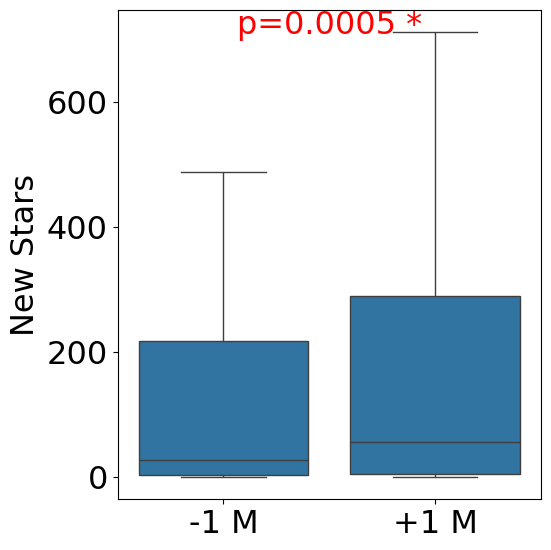

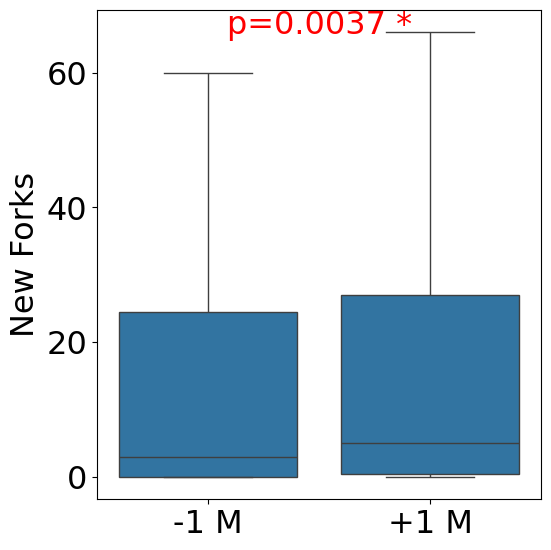

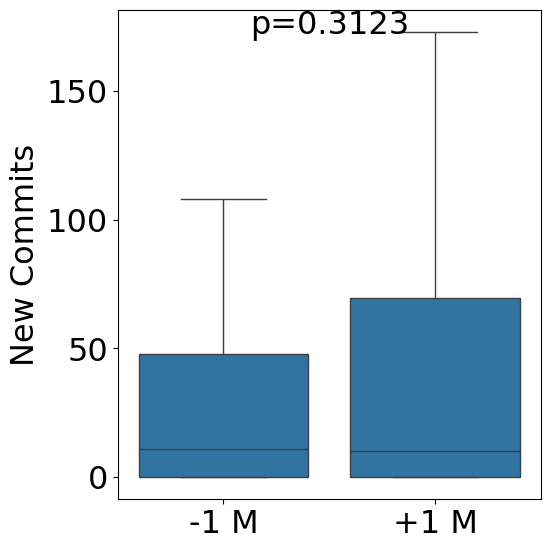

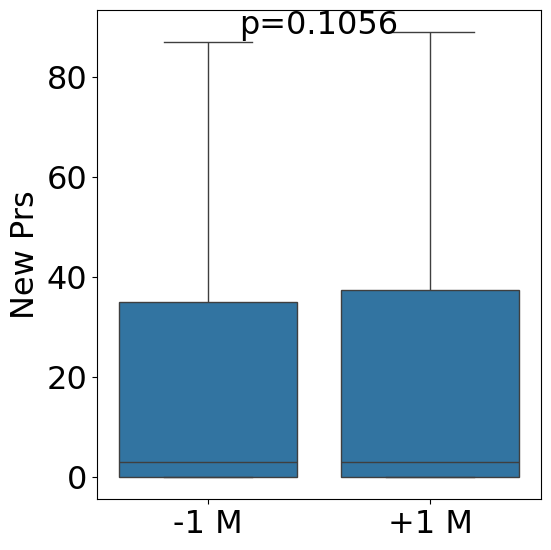

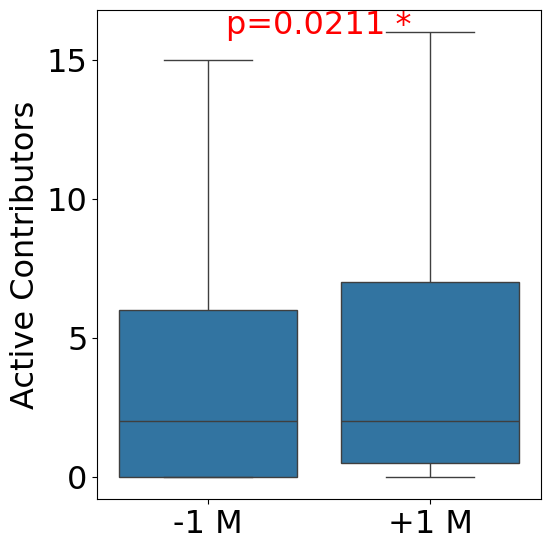


Summary Table:
             Metric                 Test Used  p-value  Mean Before  Mean After  Mean Diff  Significant
          new_stars Wilcoxon signed-rank test 0.000485   246.371069  338.842767  92.471698         True
          new_forks Wilcoxon signed-rank test 0.003692    32.528302   44.088050  11.559748         True
        new_commits Wilcoxon signed-rank test 0.312277    82.433962   89.855346   7.421384        False
            new_prs Wilcoxon signed-rank test 0.105604    45.943396   53.660377   7.716981        False
active_contributors Wilcoxon signed-rank test 0.021111     7.270440    8.490566   1.220126         True


In [ ]:
import os

# Output directory for plots
output_dir = './figs/'
os.makedirs(output_dir, exist_ok=True)

# Create boxplots
plt.rcParams['font.size'] = 23
for metric in metrics:
    plt.figure(figsize=(6, 6))

    metric_data = comparison_df[comparison_df['metric'] == metric]
    plot_data = pd.melt(metric_data[['before', 'after']],
                        var_name='Period', value_name='Value')

    # Map 'before' to '-1 Month' and 'after' to '+1 Month'
    plot_data['Period'] = plot_data['Period'].map({'before': '-1 M', 'after': '+1 M'})

    sns.boxplot(x='Period', y='Value', data=plot_data, showfliers=False)
    # plt.title(f'{metric} Before and After HN Submission')
    plt.ylabel(metric.replace('_', ' ').title())
    plt.xlabel('')

    # Add statistical significance annotation
    if results[metric]['significant']:
        plt.annotate(f"p={results[metric]['p_value']:.4f} *",
                     xy=(0.5, 0.95), xycoords='axes fraction',
                     ha='center', color='red')
    else:
        plt.annotate(f"p={results[metric]['p_value']:.4f}",
                     xy=(0.5, 0.95), xycoords='axes fraction',
                     ha='center')

    plt.tight_layout()
    plt.savefig(f'{output_dir}hn_impact_boxplot_{metric}.pdf', format="pdf")  # Save each plot separately
    plt.show()

# Summary table of results
summary_df = pd.DataFrame({
    'Metric': results.keys(),
    'Test Used': [results[m]['test'] for m in results],
    'p-value': [results[m]['p_value'] for m in results],
    'Mean Before': [results[m]['mean_before'] for m in results],
    'Mean After': [results[m]['mean_after'] for m in results],
    'Mean Diff': [results[m]['mean_diff'] for m in results],
    'Significant': [results[m]['significant'] for m in results]
})

print("\nSummary Table:")
print(summary_df.to_string(index=False))